In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sys
from scipy.stats import norm
sys.path.insert(0, '../src')
import extract_autonomous as ea
import seaborn as sns
%matplotlib inline

trial_type = 'all'
data_filename = '../data/intermediate/rockstar.p'
lfads_filename = "/home/pmalonis/226_figs/rockstar_8QTVEk_%s.h5"%trial_type

dt = 0.01
plot_binsize = 0.002 # bin size for plotting, in seconds
plot_binsize_ms = int(plot_binsize*1000)
smooth_sigma = .020 # smoothing window sigma, in seconds
n_plots = 10

with h5py.File(lfads_filename, 'r') as h5file:
    co = np.array(h5file['controller_outputs']) 
    trial_len = h5file['factors'].shape[1] * dt #trial length cutoff used

df = pd.read_pickle(data_filename)

counts = ea.segment_spike_counts(df, co, bin_size=plot_binsize_ms)

interval_len = int(ea.min_segment/plot_binsize)
counts = np.array([c[:interval_len,:] for c in counts])
n_intervals = len(counts)

intervals = ea.random_intervals(df, n_intervals, ea.min_segment, trial_len, bin_size=plot_binsize_ms)

top_idx = np.argsort(counts.sum(axis=(0,1)))[-n_plots:][::-1] #top firing neurons in descending order

In [8]:
step = plot_binsize/smooth_sigma
kernel = norm.pdf(np.arange(-3, 3+step, step)) #inclusive endpoint so kernel is centered
kernel /= np.sum(kernel)
kernel /= plot_binsize

smoothed_counts = np.zeros((n_intervals, interval_len-(len(kernel)-1), n_plots))
smoothed_intervals = np.zeros((n_intervals, interval_len-(len(kernel)-1), n_plots))

for j in range(n_intervals):
    smoothed_counts[j,:,:] = np.array([np.convolve(counts[j,:,i], kernel, 'valid') for i in top_idx]).T
    smoothed_intervals[j,:,:] = np.array([np.convolve(intervals[j,:,i], kernel, 'valid') for i in top_idx]).T

mean_counts = smoothed_counts.mean(axis=0)
mean_intervals = smoothed_intervals.mean(axis=0)
sem_counts = smoothed_counts.std(axis=0)/np.sqrt(n_intervals)
sem_intervals = smoothed_intervals.std(axis=0)/np.sqrt(n_intervals)

Here I compare the periods that LFADs identifies as not having inputs to random intervals of the data. I use periods of 500ms. Below is the comparison of firing rates for a sample of 10 neurons (those with the 10 highest average firing rates). The shaded error is +/- SEM. Some of the have a mean firing rate that evolves over the low-input interval. The fact that the changes in firing rate over the intervals don't average out is consistent with some level of repeated dynamics during the low LFDAS input period.

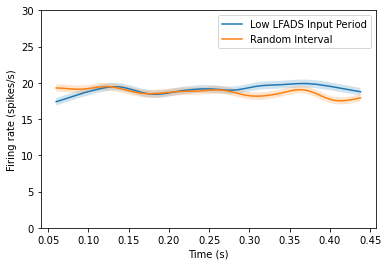

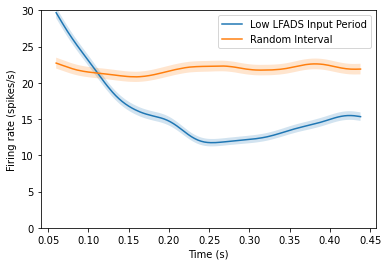

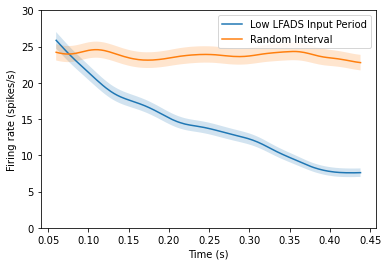

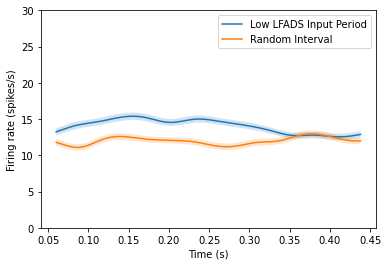

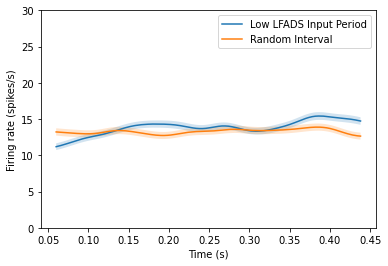

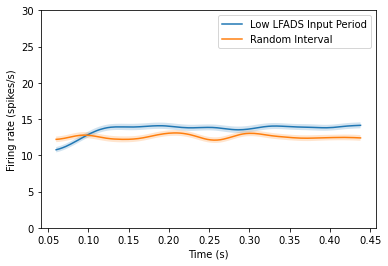

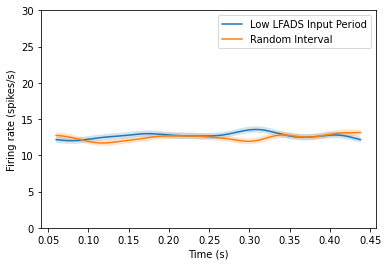

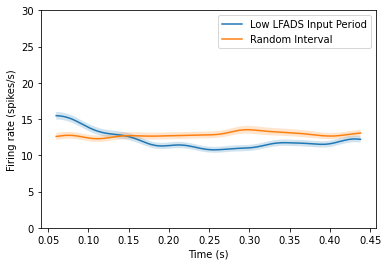

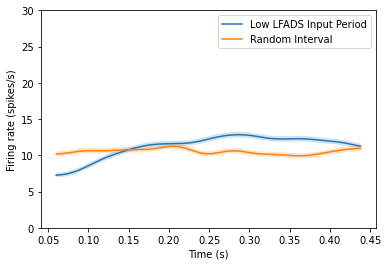

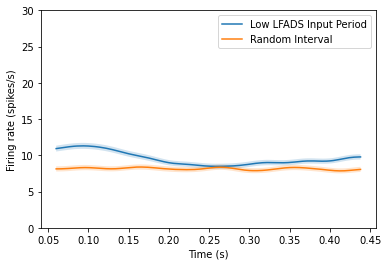

In [10]:
pad_len = len(kernel)//2
t = np.arange(counts.shape[1]) * plot_binsize
t = t[pad_len:-pad_len]

for i in range(len(top_idx)):
    plt.figure()
    plt.plot(t, mean_counts[:,i])
    plt.fill_between(t, mean_counts[:,i] - sem_counts[:,i], mean_counts[:,i] + sem_counts[:,i], alpha=0.2)
    plt.plot(t, mean_intervals[:,i])
    plt.fill_between(t, mean_intervals[:,i] - sem_intervals[:,i], mean_intervals[:,i] + sem_intervals[:,i], alpha=0.2)
    plt.legend(['Low LFADS Input Period', 'Random Interval'])
    plt.xlabel('Time (s)')
    plt.ylabel('Firing rate (spikes/s)')
    plt.ylim([0,30])

Below is the same comparison for the mean population firing rate.

Text(0.5, 0, 'Time (s)')

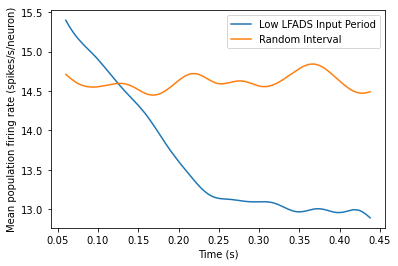

In [11]:
plt.figure()
plt.plot(t, smoothed_counts.mean(axis=2).mean(axis=0))
#plt.fill_between(t, mean_counts[:,i] - sem_counts[:,i], mean_counts[:,i] + sem_counts[:,i], alpha=0.2)
plt.plot(t, smoothed_intervals.mean(axis=2).mean(axis=0))
#plt.fill_between(t, mean_intervals[:,i] - sem_intervals[:,i], mean_intervals[:,i] + sem_intervals[:,i], alpha=0.2)
plt.legend(['Low LFADS Input Period', 'Random Interval'])
plt.ylabel('Mean population firing rate (spikes/s/neuron)')
plt.xlabel('Time (s)')

In [52]:
from sklearn.decomposition import PCA

smoothed_counts = np.zeros((n_intervals, interval_len-(len(kernel)-1), counts.shape[2]))
smoothed_intervals = np.zeros((n_intervals, interval_len-(len(kernel)-1), counts.shape[2]))

for j in range(n_intervals):
    smoothed_counts[j,:,:] = np.array([np.convolve(counts[j,:,i], kernel, 'valid') for i in range(counts.shape[2])]).T
    smoothed_intervals[j,:,:] = np.array([np.convolve(intervals[j,:,i], kernel, 'valid') for i in range(counts.shape[2])]).T

smoothed_counts /= plot_binsize
smoothed_intervals /= plot_binsize
mean_counts = smoothed_counts.mean(axis=0)
mean_intervals = smoothed_intervals.mean(axis=0)

Finally, here is the same comparison but for the mean projection onto the top 5 principal components. Again this points to some level of repeated dynamics during the low LFDAS input period.

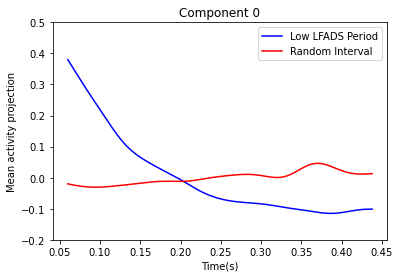

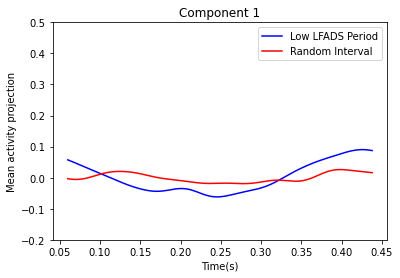

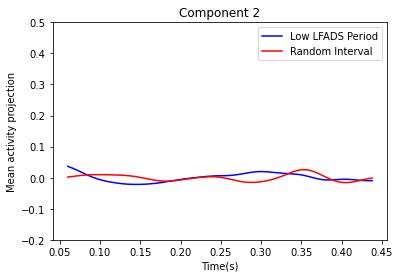

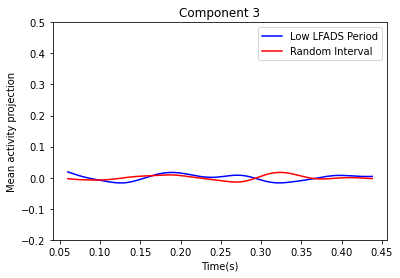

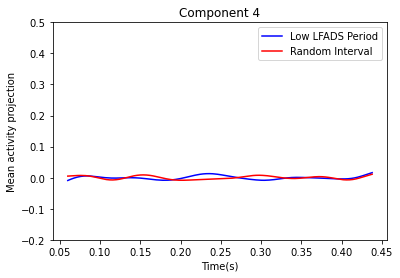

In [124]:
pca_counts = PCA(n_components=n_plots)
reduced_counts = pca_counts.fit_transform(mean_counts)
pca_intervals = PCA(n_components=n_plots)
reduced_intervals = pca_intervals.fit_transform(mean_intervals)

for i in range(5):
    plt.figure()
    plt.plot(t, reduced_counts[:,i],'b')
    #plt.fill_between(t, mean_counts[:,i] - sem_counts[:,i], mean_counts[:,i] + sem_counts[:,i], alpha=0.2)
    plt.plot(t, reduced_intervals[:,i], 'r')
    #plt.fill_between(t, mean_intervals[:,i] - sem_intervals[:,i], mean_intervals[:,i] + sem_intervals[:,i], alpha=0.2)
    plt.title('Component %d'%i)
    plt.xlabel('Time(s)')
    plt.ylabel('Mean activity projection')
    plt.legend(['Low LFADS Input Period', 'Random Interval'])
    plt.ylim([-.2, 0.5])

Next I fit attempt to fit a Poisson Linear Dynamical Systems model to the Low-LFADS-input periods, using an EM algorithm. This has not worked out so far. Below is a plot of the log-likelihood over EM steps, to show that the training reaches an asymptote. 

Text(0, 0.5, 'Log likelihood')

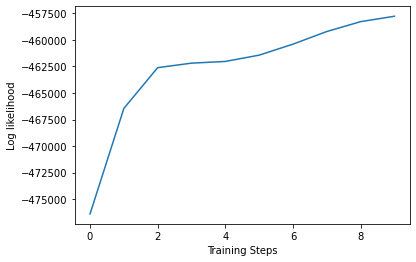

In [3]:
import extract_autonomous as ea
import os
import contextlib


lds_binsize = 0.025
lds_binsize_ms = int(lds_binsize * 1000)
n_steps = 10
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    model, ll = ea.train_model(df, co, n_steps, bin_size=lds_binsize_ms)

steps = np.arange(len(ll))
plt.plot(steps, ll)
plt.xlabel('Training Steps')
plt.ylabel('Log likelihood')

Here are some single-trial single-neuron predictions of the PLDS model.

In [14]:
counts = ea.segment_spike_counts(df, co, bin_size=lds_binsize_ms)
_,test_counts = ea.split_segments(counts)
predicted = ea.get_forward_prediction(model, test_counts)

../src/extract_autonomous.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  state_t, _, _, _ = np.linalg.lstsq(model.C, obs_init)


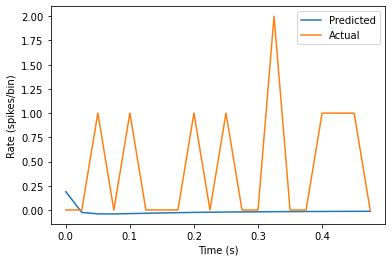

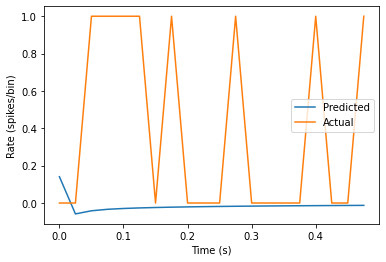

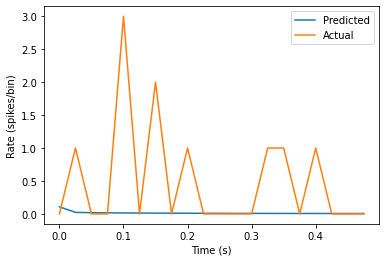

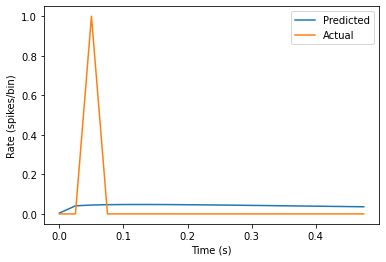

In [15]:
interval_len = int(ea.min_segment/lds_binsize)
counts = np.array([c[:interval_len,:] for c in counts])
predicted = np.array([c[:interval_len,:] for c in predicted])
t = np.arange(counts.shape[1]) * lds_binsize
for i in top_idx:
    for trial in range(len(test_counts))[:1]:
        if predicted[trial][0,i] < 0:
            continue
        plt.figure()
        plt.plot(t, predicted[trial,:,i])
        plt.plot(t, counts[trial,:,i])
        plt.xlabel('Time (s)')
        plt.ylabel('Rate (spikes/bin)')
        plt.legend(['Predicted', 'Actual'])

In [139]:
ea.min_segment/lds_binsize

20.0

Here is the average rate (predicted and actual) for the same neurons. It appears that the model simply captures a decay in activity and not any multi-phasic response properties.

In [21]:
mean_predicted = np.array([c[:20] for c in predicted]).mean(axis=0)
mean_counts = np.array([c[:20] for c in test_counts]).mean(axis=0)
print(np.argsort(mean_counts.sum(axis=0)))

[ 0 12  3 76 20 81 64 68 25 51 83 46 53 19 52 72 50 98 85 70 22 56 16 48
 24 99 45 96 44  7 84 34 31  4 90 33 29 11 77 62 43 86 42 82 60 37 13 69
 57 38 17 59 35  6  2 89 26 49  1 67 27 54 41 87 39 14  8 10 73 18  9 63
 32 30 47 93 97 92 28 23 61 79 40 78 74 58  5 36 66 55 95 80 65 71 75 91
 88 15 94 21]


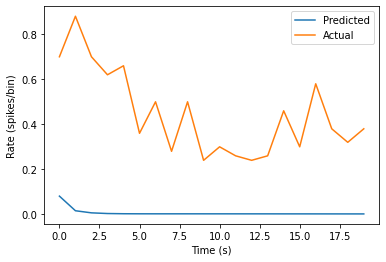

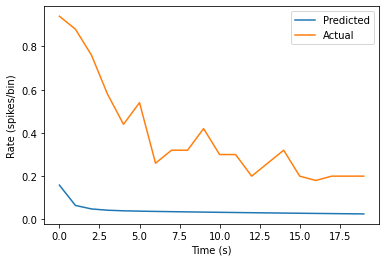

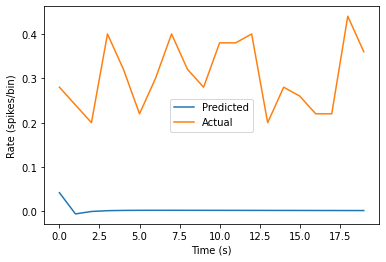

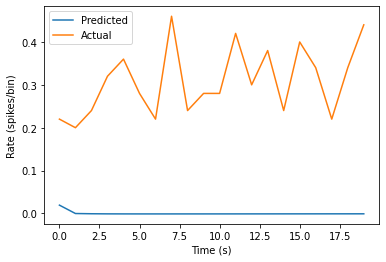

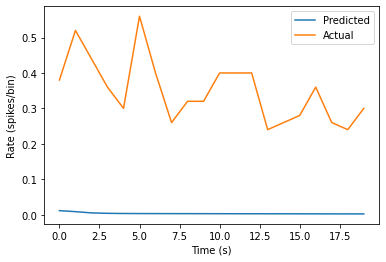

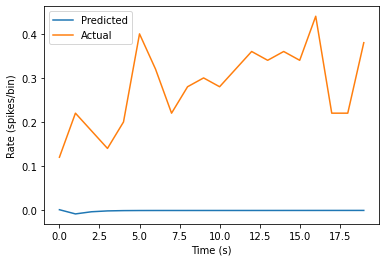

In [22]:
for i in top_idx:
    if mean_predicted[0,i] < 0:
        continue
    plt.figure()
    plt.plot(mean_predicted[:,i])
    plt.plot(mean_counts[:,i])
    plt.xlabel('Time (s)')
    plt.ylabel('Rate (spikes/bin)')
    plt.legend(['Predicted', 'Actual'])